Expectation–Maximization (EM) Algorithm Lab
-----


By The End Of This Session You Should Be Able To:
----
- Apply EM to find the mixture of two Guassian Distrubtions

In [1]:
reset -fs

In [2]:
from random import uniform
from math import sqrt, log, exp, pi

import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std
import pandas as pd
from scipy import stats
import seaborn as sns

%matplotlib inline

In [5]:
df = pd.read_csv("../data/em_example.csv")
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


__TODO__: Plot distribution

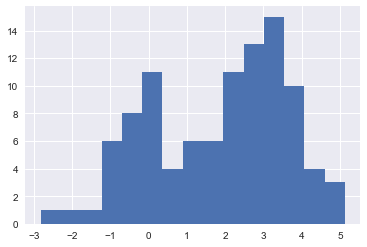

In [14]:
plt.hist(df.iloc[:,0],bins=15);

__TODO__: Is the normal distribution a useful model for the data?

In [ ]:
# No - it is a bimodal distribution

__TODO__: Plot a Kernel Density Estimation (KDE) on the data:

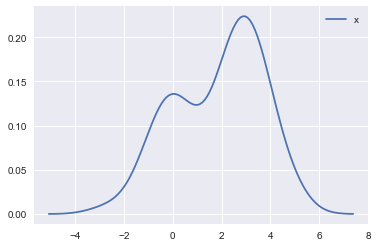

In [9]:
sns.kdeplot(df.iloc[:,0])

__TODO__:  What model should we fit?

In [10]:
# Two normal distributions - bivariate normal 

__TODO__:  Define the model:

<br>
<details><summary>
Click here for a small hint…
</summary>
The model is should be the simplest that is able generate that figure
</details>
<br>
<details><summary>
Click here for a big hint…
</summary>
The model is two Normal distributions
</details>

N1 ~ N($\mu_1,\sigma_1$)

N2 ~ N($\mu_2,\sigma_2$)

__TODO__:  List the model parameters:

<br>
<details><summary>
Click here for a small hint…
</summary>
There are 5 paramaters
</details>
<br>
<details><summary>
Click here for a big hint…
</summary>
There are 5 paramaters: 4 of the them are Normal distributions, the last one is the probability of choosing one of them
</details>


Two means ~ $\mu_1,\mu_2$

Two standard deviations ~ $\sigma_1,\sigma_2$

Latent variable(which distributions each data point belong to) a probability distribution ~ $Z$

__TODO__:  Define the probability density function (PDF):

F(X|$Z$) = $(1-Z)*(N1|\sigma_1,\mu_1)+(Z)*(N2|\sigma_2,\mu_2)$



$X$ is the observed data, $Z$ is the unobserved class membership.   

Let $Z = 1$ if the data comes from the first Normal, and $0$ otherwise, then $E(Z) = w$. 

__TODO__:  Write the E  step. Either formally or informally.

Q = E[F($\sigma^t_{1,2},\mu^t_{1,2}$|$Z,\sigma^{t-1}_{1,2},\mu^{t-1}_{1,2}$)]= $\sum_{Xi}[(w)*(N1|\sigma^{t-1}_1,\mu^{t-1}_1)+(1-w)*(N2|\sigma^{t-1}_2,\mu^{t-1}_2]$

__TODO__:  Write the M step. Either formally or informally.

M = $argmax_{\sigma_{1,2},\mu_{1,2},Z}(Q) $

In [347]:
class Gaussian:
    "Model univariate Gaussian"

    def __init__(self, mu=None, sigma=None):
        self.mu = mu
        self.sigma = sigma

    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        try:
            y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
            return y
        except ZeroDivisionError:
            return 0
        


In [348]:
from math import sqrt

In [433]:
# TODO:  Complete Gaussian Mixture class 
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=.1, mu_max=2, sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(np.random.uniform(mu_min,mu_max),np.random.uniform(sigma_min,sigma_max))
        self.two = Gaussian(np.random.uniform(mu_min,mu_max),np.random.uniform(sigma_min,sigma_max))
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        weights = []
        self.loglike= 0.
        for idx,d in enumerate(self.data):
            weights.append((self.mix * self.two.pdf(d)) / ((1-self.mix)*self.one.pdf(d)+self.mix*self.two.pdf(d)))
            self.loglike += np.log(weights[idx]+(1-weights[idx]))
        self.weights = weights
   

    def Mstep(self, weights=None):
        "Perform an M(aximization)-step"
        num_mu1 = 0
        denom_mu1 = 0
        mu1 = 0
        num_mu2 =0
        denom_mu2 = 0
        mu2 = 0

        num_sig1 = 0
        denom_sig1 =0
        sig1 = 0
        
        num_sig2 = 0
        denom_sig2 = 0
        sig2 = 0
        
        for r,d in zip(self.weights,self.data): # update means
            num_mu1+=(1-r)*d
            denom_mu1 +=(1-r)
            num_mu2+=r*d
            denom_mu2 += r
            
        mu1 = num_mu1 / denom_mu1
        mu2 = num_mu2 / denom_mu2
        
        
        for r,d in zip(self.weights,self.data): # update std
            num_sig1 += ((1-r)*(d-mu1))**2
            num_sig2 +=(r*(d-mu2))**2
        sig1 = sqrt(num_sig1 / denom_mu1)
        sig2 = sqrt(num_sig2 / denom_mu2)
        # update distributions
        self.one.mu = mu1
        self.one.sigma = sig1
        self.two.mu = mu2
        self.two.sigma = sig2

        self.mix = denom_mu2 / len(self.data)


        

    def iterate(self, N=1, restarts = 100):
        "Perform N iterations, then compute log-likelihood"

        one = []
        two = []
        mixture = []

        for r in range(restarts):
            for i in range(N):
                self.Estep()
                self.Mstep()
            one.append(self.one)
            two.append(self.two)
            mixture.append(self.mix)
        return 'mu1',np.sum([i.mu for i in one])/restarts, 'mu2',np.sum([i.mu for i in two])/restarts,\
            'sig1',np.sum([i.sigma for i in one])/restarts, 'sig2',np.sum([i.sigma for i in two])/restarts,'mixture', np.mean(mixture)
           





    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                        self.two, self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, self.mix)

In [434]:
g_mix = GaussianMixture(df.x)

In [435]:
g_mix.iterate(1_000)

('mu1',
 -0.16761999006936099,
 'mu2',
 3.0268105658433542,
 'sig1',
 0.82085813149246989,
 'sig2',
 0.81077573585302898,
 'mixture',
 0.63562812572684457)

In [131]:
# TODO: Find best single Gaussian model

mu 1.86284991695 sigma 1.77021613224


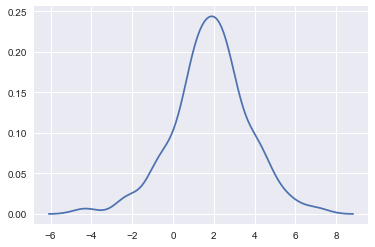

In [436]:
norm_params = stats.norm.fit(df.x)
sns.kdeplot(stats.norm(*norm_params).rvs(100))
print('mu',norm_params[0],'sigma',norm_params[1])

In [132]:
# TODO: Find best Mixture Gaussian model

In [340]:
print('Best Guassian Mixture:')
print('1st Guassian: μ = {:.2}, σ = {:.2}'.format(g_mix.one.mu, g_mix.one.sigma))
print('2nd Guassian: μ = {:.2}, σ = {:.2}'.format(g_mix.two.mu, g_mix.two.sigma))
print(f'Guassian mixture: {g_mix.mix:.2}')

"""Shoule be ~ like this:
Best Guassian Mixture:
1st Guassian: μ = 2.6, σ = 1.2
2nd Guassian: μ = -0.48, σ = 0.8
Guassian mixture: 0.75
"""

Best Guassian Mixture:
1st Guassian: μ = -0.17, σ = 0.82
2nd Guassian: μ = 3.0, σ = 0.81
Guassian mixture: 0.64


'Shoule be ~ like this:\nBest Guassian Mixture:\n1st Guassian: μ = 2.6, σ = 1.2\n2nd Guassian: μ = -0.48, σ = 0.8\nGuassian mixture: 0.75\n'

----
Challenge Activities
------

Plot the estimated pdfs, univariate and mixture:

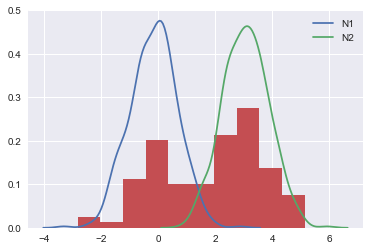

In [441]:
sns.kdeplot(stats.norm(-0.16761999006936099,0.82085813149246989).rvs(500),label='N1')
sns.kdeplot(stats.norm(3.0268105658433542,0.81077573585302898).rvs(500),label='N2')
plt.hist(df.x, normed=True,label='true data');

<br>
<br>